In [1]:
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax
from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
import csv
import sys
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy

from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))
#config.update('jax_debug_nans', True)
from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters, create_gratings

#initialize key
key = random.PRNGKey(9)

jax backend cpu


In [2]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 5

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 15, jitter_val = 5)
stimuli_pars.update(general_pars)

In [3]:
#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
#sigEI, sigII = .2, .2
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
filter_pars.update(general_pars) 


#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)


#Excitatory and inhibitory constants for extra synaptic GABA
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25

#key, _ = random.split(key)
#w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
w_sig = numpy.random.normal(size=(N_neurons,)) / np.sqrt(N_neurons)
#w_sig = np.zeros((N_neurons))
b_sig = 0.0

#Optimization pars
#opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)

#New parameter definition
ssn_layer_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2,  c_E = c_E, c_I = c_I)
readout_pars = dict(w_sig = w_sig, b_sig=b_sig)

#Convergence parameters
conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 400, verbose=False, silent=True)
w_sig

DeviceArray([ 0.13481294,  0.20778652,  0.06622782, -0.11762931,
             -0.16242339, -0.184947  ,  0.03769583, -0.11508729,
             -0.13416171,  0.19343194,  0.01351118,  0.01507693,
              0.03158078,  0.10379797, -0.06307949,  0.18099323,
             -0.1573692 , -0.09256339,  0.03019799, -0.16311917,
              0.31637627, -0.01080486, -0.20795369, -0.00944763,
             -0.13041905], dtype=float32)

In [4]:
#Number of epochs
epochs = 100
num_epochs_to_save = 21
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)

In [5]:
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data


def save_params_dict(ssn_layer_pars, readout_pars , accuracy, epoch ):
    
    J_2x2, s_2x2 = exponentiate(ssn_layer_pars)
     
    save_params= dict(val_accuracy= accuracy, 
                J_EE= J_2x2[0,0], J_EI = J_2x2[0,1], 
                              J_IE = J_2x2[1,0], J_II = J_2x2[1,1], 
                s_EE= s_2x2[0,0], s_EI = s_2x2[0,1], 
                              s_IE = s_2x2[1,0], s_II = s_2x2[1,1],
                c_E = ssn_layer_pars['c_E'], c_I = ssn_layer_pars['c_I'], 
                 epoch = epoch, w_sig = readout_pars['w_sig'], b_sig=readout_pars['b_sig'])
    
    return save_params

def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def sigmoid(x):
    return 1/(1+np.exp(x))

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    return J_2x2, s_2x2

def our_max(x, beta=1):
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val

def model(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, Rmax_E = 50, Rmax_I = 100, lam_1=1, lam_2=1):
    
    J_2x2, s_2x2 = exponentiate(ssn_layer_pars)
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(ssn_layer_pars['c_E'], ssn_layer_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])
    
    #Find fixed point response + select centre neurons
    fp_ref, _, avg_dx_ref = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)
    r_max_ref = np.maximum(0, (our_max(fp_ref[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp_ref[ssn.Ne:-1])/Rmax_I - 1))
    
    fp_target, _, avg_dx_target = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)
    r_max_target = our_max(fp_target[:ssn.Ne])/Rmax_E  + our_max(fp_target[ssn.Ne:-1])/Rmax_I

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(readout_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + readout_pars['b_sig'])

    #Calculate binary cross entropy loss
    loss=binary_loss(train_data['label'], x)
    
    #Combine loss with maximum rate and dx value
    mag=np.abs(loss)
    loss = loss + (lam_1*(avg_dx_ref + avg_dx_target)/2 + lam_2*(r_max_ref + r_max_target)/2)*mag
   
    return loss


def loss(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars):
    
    '''
    Calculate parallelized loss for batch of data through vmap.
    Output:
        mean loss of all the input images
    '''
    
    vmap_model = vmap(model, in_axes = ({'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None}, {'b_sig': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )                   
    loss = np.sum(vmap_model(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars))

    return loss




def eval_model(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, Rmax_E = 50, Rmax_I = 100, lam_1=1, lam_2=1):
    
    J_2x2, s_2x2 = exponentiate(ssn_layer_pars)
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(ssn_layer_pars['c_E'], ssn_layer_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])
    
    #Find fixed point response + select centre neurons
    fp_ref, _, avg_dx_ref = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)
    r_max_ref = np.maximum(0, (our_max(fp_ref[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp_ref[ssn.Ne:-1])/Rmax_I - 1))
    
    fp_target, _, avg_dx_target = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)
    r_max_target = our_max(fp_target[:ssn.Ne])/Rmax_E  + our_max(fp_target[ssn.Ne:-1])/Rmax_I

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(readout_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + readout_pars['b_sig'])

    #Calculate binary cross entropy loss
    loss=binary_loss(train_data['label'], x)
    
    #Combine loss with maximum rate and dx value
    mag=np.abs(loss)
    loss = loss + (lam_1*(avg_dx_ref + avg_dx_target)/2 + lam_2*(r_max_ref + r_max_target)/2)*mag
    
    #compare prediction to label
    pred_label = np.round(x)

    return loss, pred_label, x


def vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    eval_vmap = vmap(eval_model, in_axes = ({'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None}, {'b_sig': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, pred_labels, dots = eval_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    
    accuracy = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, accuracy, dots


def train_SSN_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars, conv_pars, epochs_to_save, opt, results_filename = None, batch_size=20, ref_ori = 55, offset = 5, epochs=1, eta=10e-4, early_stop=0.7):
    
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
    
        
    #Initialise optimizer
    optimizer = optax.adam(eta)
    if opt=='readout':
        opt_state = optimizer.init(readout_pars)
    if opt=='ssn':
        opt_state = optimizer.init(ssn_layer_pars)
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
    val_loss, accuracy, _= vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    print('Before training  -- loss: {}, accuracy: {} '.format(val_loss, accuracy))
    val_loss_per_epoch.append(val_loss)
    
    #Save initial parameters
    save_params = save_params_dict(ssn_layer_pars, readout_pars, accuracy=accuracy, epoch=0 )
    
    #Initialise csv file
    if results_filename:
        #AVOID OVERWRITING FILES? 
        results_handle = open(results_filename, 'w')
        results_writer=None
        results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
        results_writer.writeheader()
        results_writer.writerow(save_params)
        print('Saving results to csv ', results_filename)
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient + apply SGD
        if opt=='readout':
            epoch_loss, grad =jax.value_and_grad(loss, 1)(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
            updates, opt_state = optimizer.update(grad, opt_state)
            readout_pars = optax.apply_updates(readout_pars, updates)
            
        if opt=='ssn':
            epoch_loss, grad =jax.value_and_grad(loss, 0)(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
            updates, opt_state = optimizer.update(grad, opt_state)
            ssn_layer_pars = optax.apply_updates(ssn_layer_pars, updates)
    
        
        epoch_time = time.time() - start_time

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
            val_loss, accuracy, _= vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
            print('Training loss: {} ¦ Validation -- loss: {}, accuracy: {} at epoch {}, (time {})'.format(epoch_loss, val_loss, accuracy, epoch, epoch_time))
            val_loss_per_epoch.append(val_loss)
            
            #Create dictionary of parameters to save
            save_params = save_params_dict(ssn_layer_pars, readout_pars, accuracy, epoch)
            
            #Write results in csv file
            if results_filename:
                results_writer.writerow(save_params)
                
           #Early stop to train readout layer 
            if accuracy>= early_stop and opt=='readout':
                print('Early stop: {} accuracy acheived'.format(early_stop))
                break
                
    #Return reparametrized params
    #ssn_layer_pars['logJ_2x2'], ssn_layer_pars['logs_2x2'] = exponentiate(ssn_layer_pars)
    
    return ssn_layer_pars, readout_pars, val_loss_per_epoch, training_losses

In [10]:
results_readout_1 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/readout_1.csv'
opt='readout'
new_ssn_layer_pars, new_readout_pars, val_loss_test, training_los_test= train_SSN_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, epochs_to_save=epochs_to_save, opt=opt,  results_filename=results_readout_1, ref_ori = 55, offset = 10, batch_size = 100, epochs = epochs)

Before training  -- loss: 13.819100379943848, accuracy: 0.7799999713897705 
Saving results to csv  /mnt/d/temp/ssn_modelling/ssn-simulator/results/readout_1.csv
Training loss: 1491.3048095703125 ¦ Validation -- loss: 15.850194931030273, accuracy: 0.7200000286102295 at epoch 1, (time 8.315176010131836)
Early stop: 0.7 accuracy acheived


In [12]:
results_ssn_layer_2 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/ssn_layer_2.csv'
opt='ssn'
final_ssn_layer_pars, final_readout_pars, val_loss_test, training_los_test= train_SSN_vmap(new_ssn_layer_pars, new_readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, epochs_to_save=epochs_to_save, opt=opt,  results_filename=results_ssn_layer_2, ref_ori = 55, offset = 10, batch_size = 100, epochs = epochs)

Before training  -- loss: 16.96786117553711, accuracy: 0.699999988079071 
Saving results to csv  /mnt/d/temp/ssn_modelling/ssn-simulator/results/ssn_layer_2.csv
Training loss: 1643.2216796875 ¦ Validation -- loss: 13.199551582336426, accuracy: 0.800000011920929 at epoch 1, (time 17.561328172683716)
Training loss: 1313.53857421875 ¦ Validation -- loss: 11.625941276550293, accuracy: 0.7099999785423279 at epoch 5, (time 14.135358810424805)
Training loss: 979.0552978515625 ¦ Validation -- loss: 10.229236602783203, accuracy: 0.7200000286102295 at epoch 10, (time 14.255053043365479)
Training loss: 774.5518798828125 ¦ Validation -- loss: 7.919118404388428, accuracy: 0.7200000286102295 at epoch 15, (time 13.96063232421875)
Training loss: 810.6167602539062 ¦ Validation -- loss: 7.2082343101501465, accuracy: 0.75 at epoch 20, (time 14.168681859970093)
Training loss: 670.8279418945312 ¦ Validation -- loss: 6.088470935821533, accuracy: 0.6499999761581421 at epoch 25, (time 14.17967700958252)
Train

In [1]:
from util import param_ratios, plot_results

results_ssn_layer_2 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/ssn_layer_2.csv'
param_ratios(results_ssn_layer_2)

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [-5  5  5 -3]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[1.0533371526668576 1.0 0.9617370999999999 1.0]
s ratios =  [ 5  0 -3  0]


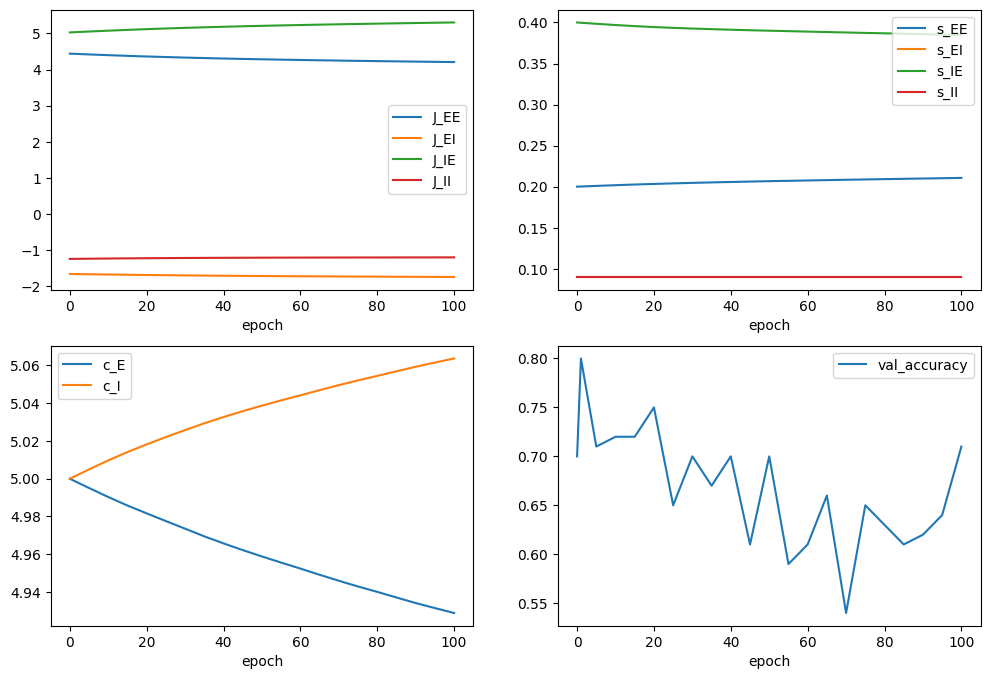

In [2]:
plot_results(results_ssn_layer_2)